# Python Regression Model for Cancer Data.ipynb


**Purpose**: Predict cancer death rates using demographic and health data from Kaggle.

**Key Steps**:

1. **Data Acquisition**:
   - Downloads dataset directly from Kaggle using kagglehub API
   - Falls back to local files if download fails

2. **Data Preparation**:
   - Merges cancer statistics with demographic data
   - Handles missing values (median imputation)
   - Processes categorical variables (one-hot encoding)
   - Selects relevant numeric features

3. **Model Building**:
   - Tests multiple algorithms:
     - Linear Regression
     - Regularized models (Ridge/Lasso)
     - Ensemble methods (Random Forest, Gradient Boosting)
   - Evaluates using MSE and R-squared metrics
   - Selects best performing model

4. **Analysis & Prediction**:
   - Shows feature importance/coefficients
   - Visualizes actual vs predicted values
   - Makes example prediction on sample data

**Key Features**:
- Robust to different dataset formats
- Maintains consistent features between training/prediction
- Provides model interpretation visuals
- Automated best model selection

**Output**:
- Performance metrics for each model
- Visualizations of results
- Prediction example using the best model

This end-to-end solution handles everything from data loading to final predictions while ensuring reproducibility and model interpretability.

100%|██████████| 339k/339k [00:00<00:00, 694kB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/varunraskar/cancer-regression/versions/1
Loading cancer data from: /root/.cache/kagglehub/datasets/varunraskar/cancer-regression/versions/1/cancer_reg.csv
Loading demographic data from: /root/.cache/kagglehub/datasets/varunraskar/cancer-regression/versions/1/avg-household-size.csv
Merged datasets on column: geography

Model: Pipeline
MSE: 411.19
R-squared: 0.50

Model: Pipeline
MSE: 411.18
R-squared: 0.50

Model: Pipeline
MSE: 410.04
R-squared: 0.50

Model: RandomForestRegressor
MSE: 367.96
R-squared: 0.55


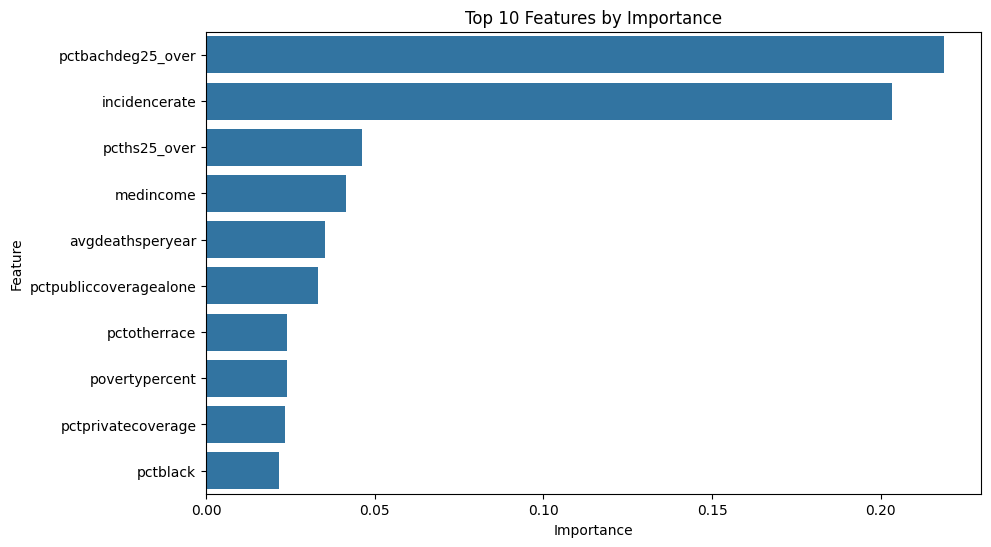


Model: GradientBoostingRegressor
MSE: 335.37
R-squared: 0.59


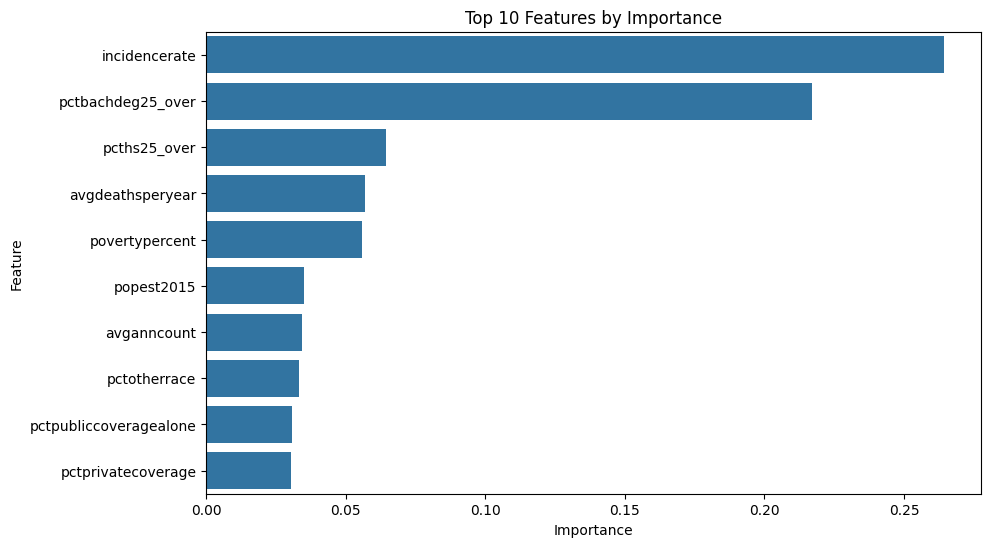


Best Model: GradientBoostingRegressor
Best R-squared: 0.59


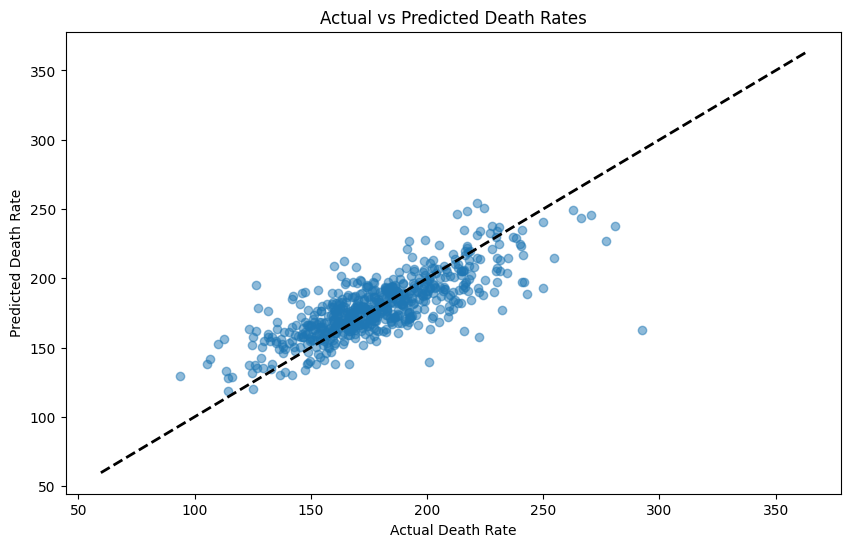


Example prediction for last row in dataset: 183.57


In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

def download_kaggle_dataset():
    """Download dataset from Kaggle using kagglehub"""
    try:
        print("Downloading dataset from Kaggle...")
        path = kagglehub.dataset_download("varunraskar/cancer-regression")
        print(f"Dataset downloaded to: {path}")

        # Find the CSV files in the downloaded directory
        csv_files = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.csv'):
                    csv_files.append(os.path.join(root, file))

        if len(csv_files) < 2:
            raise FileNotFoundError("Could not find both required CSV files in the downloaded dataset")

        return csv_files
    except Exception as e:
        print(f"Error downloading dataset from Kaggle: {e}")
        return None

def load_data(csv_files):
    """Load and merge the datasets"""
    # Identify which file is which based on size or name
    file_sizes = [(f, os.path.getsize(f)) for f in csv_files]
    file_sizes.sort(key=lambda x: x[1], reverse=True)

    # Assume larger file is cancer data (more columns), smaller is demographic data
    cancer_file = file_sizes[0][0]
    demo_file = file_sizes[1][0]

    print(f"Loading cancer data from: {cancer_file}")
    print(f"Loading demographic data from: {demo_file}")

    df_cancer = pd.read_csv(cancer_file)
    df_demo = pd.read_csv(demo_file)

    return df_cancer, df_demo

def preprocess_data(df_cancer, df_demo):
    """Merge and preprocess the datasets"""
    # Merge datasets - try different possible merge keys
    merge_success = False
    df = df_cancer.copy()

    # Try common merge keys
    for merge_key in ['geography', 'countyfips', 'County']:
        if merge_key in df_cancer.columns and merge_key in df_demo.columns:
            df = pd.merge(df_cancer, df_demo, on=merge_key, how='left')
            merge_success = True
            print(f"Merged datasets on column: {merge_key}")
            break

    if not merge_success:
        print("Could not find common column to merge datasets. Using only cancer data.")
        df = df_cancer.copy()

    # Data preprocessing
    # Handle missing values - fill with median for numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    imputer = SimpleImputer(strategy='median')
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Convert categorical variables if any (like binnedinc)
    categorical_cols = ['binnedinc']  # add any other categorical columns here
    for col in categorical_cols:
        if col in df.columns:
            df = pd.get_dummies(df, columns=[col], drop_first=True)

    return df

def build_regression_model(df):
    """Build and evaluate regression models"""
    # Feature selection - we need to be consistent with features used in training and prediction
    exclude_cols = ['target_deathrate', 'geography', 'County', 'State']  # exclude identifiers

    # We'll keep all numeric features except the target and identifiers
    features = [col for col in df.columns
                if col not in exclude_cols
                and df[col].dtype in ['int64', 'float64', 'uint8']]

    target = 'target_deathrate'

    if target not in df.columns:
        raise ValueError("Target column 'target_deathrate' not found in dataset")

    X = df[features]
    y = df[target]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model evaluation function
    def evaluate_model(model, X_train, X_test, y_train, y_test):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"\nModel: {model.__class__.__name__}")
        print(f"MSE: {mse:.2f}")
        print(f"R-squared: {r2:.2f}")

        # Feature importance/coefficients
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            importance_type = 'Importance'
        elif hasattr(model, 'coef_'):
            importance = model.coef_
            importance_type = 'Coefficient'
        else:
            return model, mse, r2

        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            importance_type: importance
        }).sort_values(importance_type, key=abs, ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importance_type, y='Feature', data=feature_importance.head(10))
        plt.title(f'Top 10 Features by {importance_type}')
        plt.show()

        return model, mse, r2

    # Try different regression models
    models = [
        Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
        Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.1))]),
        Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.1))]),
        RandomForestRegressor(n_estimators=100, random_state=42),
        GradientBoostingRegressor(n_estimators=100, random_state=42)
    ]

    results = []
    for model in models:
        fitted_model, mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append({
            'model': model.__class__.__name__,
            'mse': mse,
            'r2': r2,
            'fitted_model': fitted_model,
            'features': X_train.columns.tolist()  # Store the feature names used in training
        })

    # Select best model
    best_model_info = max(results, key=lambda x: x['r2'])
    best_model = best_model_info['fitted_model']
    features_used = best_model_info['features']

    print(f"\nBest Model: {best_model.__class__.__name__}")
    print(f"Best R-squared: {best_model_info['r2']:.2f}")

    # Visualize predictions vs actual
    y_pred = best_model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual Death Rate')
    plt.ylabel('Predicted Death Rate')
    plt.title('Actual vs Predicted Death Rates')
    plt.show()

    return best_model, features_used

def main():
    # Download dataset from Kaggle
    csv_files = download_kaggle_dataset()

    if not csv_files:
        print("Failed to download dataset. Using local files if available...")
        # Fallback to local files if available
        csv_files = [f for f in os.listdir() if f.endswith('.csv')]
        if len(csv_files) < 2:
            raise FileNotFoundError("Could not find required CSV files")

    # Load and preprocess data
    df_cancer, df_demo = load_data(csv_files)
    df = preprocess_data(df_cancer, df_demo)

    # Build and evaluate regression model
    model, features_used = build_regression_model(df)

    # Example prediction - ensure we use the same features as in training
    example_data = df[features_used].iloc[-1:].copy()
    prediction = model.predict(example_data)
    print(f"\nExample prediction for last row in dataset: {prediction[0]:.2f}")

if __name__ == "__main__":
    main()